# Gravitational Wave Skymap and Galaxy Catalog Search Example: BBH S190521g and AllWISE AGN Catalog

Authors: Amanda Beck, Zsuzsa Marka

## Index:

1. [Gravitational Wave Data for BBH Merger](#Gravitational-Wave-Data-for-BBH-Merger:)
    1. [Isolating 90% Probability Area](#Isolating-90%-Probability-Area:)
2. [AllWISE AGN Catalog Data](#AllWISE-AGN-Catalog-Data:)
    1. [Inserting AGN into Healpy Skymap](#Inserting-AGN-into-Healpy-Skymap:)
3. [Crossmatch](#Crossmatch:)
4. [Resources](#Resources:)

In [1]:
# general imports:
from astropy.table import Column, Table, join
from astropy.coordinates import SkyCoord
from matplotlib import pyplot as plt
import astropy.coordinates as coord
from astropy.io import fits, ascii
import astropy.units as u
import ligo.skymap.moc
import healpy as hp
import numpy as np

# imports from src code:
import sys
sys.path.append('../src')
from functions import plot_mollview

# defining plot inclusion in notebook:
%matplotlib inline

## Gravitational Wave Data for BBH Merger:

Data for S190521g can be found in GraceDB's Public Alerts page. The link can be found in [Resources](#Resources:).

In [2]:
# opening BBH LIGO data:
S190521g = '../data/S190521g/bayestar2.fits' 
bbh_data = Table.read(S190521g)

# adding an index row to prevent pixel scrambling:
index = Column(np.arange(len(bbh_data)), name='INDEX')
bbh_data.add_column(index, index=0)

# getting nside value:
nside = int((len(bbh_data))/12)**(1/2)

bbh_data[:5]

INDEX,PROB,DISTMU,DISTSIGMA,DISTNORM
,1 / pix,Mpc,Mpc,1 / Mpc2
int64,float64,float64,float64,float64
0,3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
1,3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
2,3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
3,3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05
4,3.420666741585511e-21,-73.1221838420601,404.8957816151533,1.642233920921469e-05


### Isolating 90% Probability Area:

In [3]:
# isolating 90% probability area:
def isolate_90_area(data, 
                    order=None):
    ''' 
    Isolates the 90% highest probability area.

    Parameters:
    -----------
    data: Table or DataFrame
        LIGO data containing pixel probability column.
        
    Returns:
    -----------
    ninety_area: Table or DataFrame
        Isolated 90% probability area pixels of the LIGO data.  
    '''
    # ordering table by probability:
    data = np.sort(data, order=order)
    # adding from top to bottom till 90% prob area:
    data = Table(data)[::-1]
    s = 0
    for i in range(len(data['PROB'])):
        ninety_area = data[:i]
        s += data['PROB'][i]
        if (s >= 0.9):
            break
    
    return ninety_area

In [4]:
bbh_ninety_area = isolate_90_area(bbh_data, order='PROB')
bbh_ninety_area[:5]

INDEX,PROB,DISTMU,DISTSIGMA,DISTNORM
int64,float64,float64,float64,float64
2140788,7.300594766653513e-05,578.6989651459575,134.65056071447785,2.8326746010215228e-06
2140790,7.299722728689103e-05,578.9672656632431,134.81122399518873,2.829837776746133e-06
2140789,7.29389530802557e-05,579.0822411319475,134.74802297664758,2.8289082668104363e-06
2140767,7.293684502413901e-05,578.8067055490524,134.5902546341876,2.831804472408014e-06
2140766,7.292514235949446e-05,578.4119804743116,134.50183436497926,2.8356635224898187e-06


In [5]:
print('Number of pixels in 90% probability area: ' + str(len(bbh_ninety_area)))

Number of pixels in 90% probability area: 88667


## AllWISE AGN Catalog Data:

For the purpose of this demonstration, we are using the AllWISE AGN catalog. The link to the catalog can be found in [Resources](#Resources:).

In [6]:
# opening BBH LIGO data:
cat = '../data/allwise.fits' 
allwise = Table.read(cat, format='fits')

# adjusting RA and DEC column names to fit with our convention:
allwise['RA'].name = 'RAJ2000'
allwise['DEC'].name = 'DEJ2000'

allwise[:5]

NAME,RAJ2000,DEJ2000,LII,BII,W1W2_COLOR,W2W3_COLOR,W1_MAG,GMAG,REDSHIFT,REDSHIFT_FLAG,LQAC2_NAME,DR12Q_NAME,MILLIQUAS_NAME
,DEGREE,DEGREE,DEGREE,DEGREE,MAG,MAG,MAG,MAG,,,,,
bytes25,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes13,bytes17,bytes24,bytes26
WISEA J184245.06-894911.0,280.68778,-89.81973,303.13432,-27.12127,0.95,3.48,15.15,0.00,0.00000,,,,
WISEA J043431.62-894617.9,68.63175,-89.77165,302.71954,-27.25653,1.32,3.07,15.12,0.00,0.00000,,,,
WISEA J220915.15-894514.2,332.31317,-89.75395,303.11194,-27.31510,0.95,3.57,16.08,0.00,0.00000,,,,
WISEA J094017.96-894442.8,145.07485,-89.74523,302.72023,-26.95691,0.96,3.16,14.27,0.00,0.00000,,,,
WISEA J233728.16-894436.2,354.36737,-89.74341,303.02356,-27.37156,1.04,3.00,15.21,0.00,0.00000,,,,


### Inserting AGN into Healpy Skymap:

In [7]:
def convert_RaDec_Index_manual(data, n_side):
    ''' 
    Manually converting RA and DEC to healpix nested pixel index (marginally faster than using astropy's methods).
    Adds pixel index, theta, and phi columns to data set.

    Parameters:
    -----------
    data: Table or DataFrame
        Must have Ra and Dec columns named as RAJ2000 and DEJ2000.
    n_side: float or int
        nside value corresponding to LIGO skymap to be crossmatched with the AGN data.
    '''
    n_side_array = np.full(len(data['RAJ2000']), int(n_side))
    theta = 0.5 * np.pi - np.deg2rad(data['DEJ2000'])
    phi = np.deg2rad(data['RAJ2000'])
    ipix = hp.ang2pix(n_side_array, theta, phi, nest=True)
    data.add_columns([np.array(ipix), theta, phi],
                     names=['INDEX', 'THETA', 'PHI'])

In [8]:
convert_RaDec_Index_manual(allwise, 
                           nside)
allwise[:5]

NAME,RAJ2000,DEJ2000,LII,BII,W1W2_COLOR,W2W3_COLOR,W1_MAG,GMAG,REDSHIFT,REDSHIFT_FLAG,LQAC2_NAME,DR12Q_NAME,MILLIQUAS_NAME,INDEX,THETA,PHI
,DEGREE,DEGREE,DEGREE,DEGREE,MAG,MAG,MAG,MAG,,,,,,,DEGREE,DEGREE
bytes25,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes13,bytes17,bytes24,bytes26,int64,float64,float64
WISEA J184245.06-894911.0,280.68778,-89.81973,303.13432,-27.12127,0.95,3.48,15.15,0.00,0.00000,,,,,2883586,3.13845,4.89893
WISEA J043431.62-894617.9,68.63175,-89.77165,302.71954,-27.25653,1.32,3.07,15.12,0.00,0.00000,,,,,2097153,3.13761,1.19785
WISEA J220915.15-894514.2,332.31317,-89.75395,303.11194,-27.31510,0.95,3.57,16.08,0.00,0.00000,,,,,2883585,3.13730,5.79996
WISEA J094017.96-894442.8,145.07485,-89.74523,302.72023,-26.95691,0.96,3.16,14.27,0.00,0.00000,,,,,2359299,3.13715,2.53203
WISEA J233728.16-894436.2,354.36737,-89.74341,303.02356,-27.37156,1.04,3.00,15.21,0.00,0.00000,,,,,2883588,3.13711,6.18488


In [9]:
def agn_counts_per_pixel(agn_index, bbh_index):
    ''' 
    Using the AGN pixel indexes, identifies how many AGN per pixel in a skymap.

    Parameters:
    -----------
    agn_indes: NdArray or Column
        AGN pixel indexes in nested ordering.
    bbh_index: NdArray or Column
        Pixel indexes in nested ordering of the current skymap. In this case, this is the INDEX column of the LIGO data.
        
    Returns:
    -----------
    agn_counts: Table or DataFrame
        AGN counts per pixel.
    hpx_map: NdArray
        AGN Healpix skymap.
    '''
    idx, counts = np.unique(agn_index, return_counts=True)
    hpx_map = np.zeros(len(bbh_index), dtype=int)
    hpx_map[idx] = counts
    agn_counts = Table([idx, counts], names=['INDEX', 'AGN COUNT'])
    
    return agn_counts, hpx_map

In [10]:
allwise_counts, allwise_hpx_map = agn_counts_per_pixel(allwise['INDEX'], bbh_data['INDEX'])
allwise_counts[:5]

INDEX,AGN COUNT
int64,int64
2,1
4,2
7,1
12,3
13,2


## Crossmatch:

In [11]:
# joining tables to get overlap:
area_matches = join(allwise, 
                    bbh_ninety_area, 
                    keys='INDEX', 
                    table_names=['AllWISE', 'LIGO'])

print('Number of AGN in 90% probability area: ' + str(len(area_matches)))

Number of AGN in 90% probability area: 48886


0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 15 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 15 deg -0.00'.
The interval between meridians is 15 deg -0.00'.


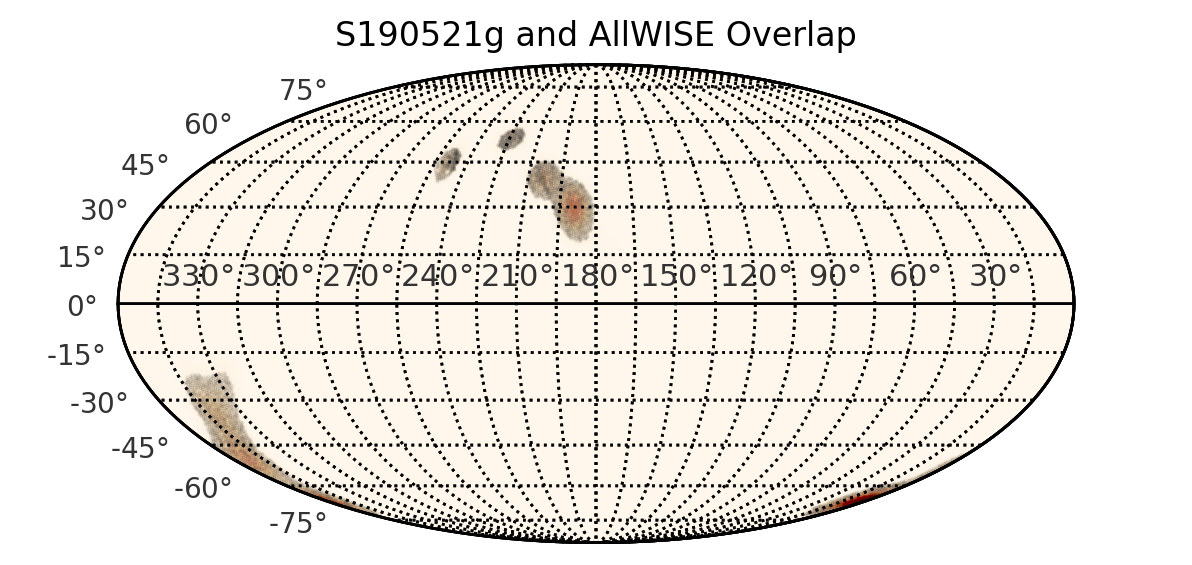

In [12]:
plot_mollview(bbh_data['PROB'], 
              nest=True, 
              cmap='OrRd', 
              title='S190521g and AllWISE Overlap', 
              unit='Prob. Density')
hp.projscatter(area_matches['RAJ2000'], 
               area_matches['DEJ2000'], 
               marker='.', 
               s=0.0001, 
               c='k', 
               lonlat=True, 
               alpha=0.5)
hp.graticule(15)

plt.savefig('../plots/bbh_agn_overlap.pdf', overwrite=True)

## Resources:

### Data:
1. [AllWISE AGN Catalog](https://heasarc.gsfc.nasa.gov/W3Browse/all/allwiseagn.html)
2. [GraceDB](https://gracedb.ligo.org/superevents/public/O3/)


### General Resources:
1. [Astropy](https://www.astropy.org)
2. [HEALPy Documentation](https://healpy.readthedocs.io/en/latest/)
2. [GWOSC](https://www.gw-openscience.org/about/)
3. [Anaconda Documentation](https://docs.anaconda.com/anaconda/)
4. [Conda Documentation](https://docs.conda.io/projects/conda/en/latest/index.html)
5. [Conda Forge](https://conda-forge.org/docs/user/introduction.html)
6. [Finding Highest Probability for Multiorder Skymaps](https://emfollow.docs.ligo.org/userguide/tutorial/multiorder_skymaps.html)
8. [Multi-Order Skymaps](https://emfollow.docs.ligo.org/userguide/tutorial/multiorder_skymaps.html)
7. [LIGO moc Documentation](https://lscsoft.docs.ligo.org/ligo.skymap/moc/index.html)
8. [RA and DEC to Degree Converter](https://www.swift.psu.edu/secure/toop/convert.htm)
9. [SCiMMA Project](https://scimma.org/index.html)